# A9 - Adv ML - Neural-Style Transfer
Jacob Toronto

Note: this is copied from https://colab.research.google.com/github/fchollet/deep-learning-with-python-notebooks/blob/master/chapter12_part03_neural-style-transfer.ipynb

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Neural style transfer

### The content loss

### The style loss

### Neural style transfer in Keras

**Getting the style and content images**

In [1]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

943128/943128 [==============================] - 0s 0us/step


In [2]:
base_image_path

'/root/.keras/datasets/sf.jpg'

**Auxiliary functions**

In [3]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    # print(img.shape)
    img = keras.utils.img_to_array(img)
    print(img.shape)
    img = np.expand_dims(img, axis=0)
    print(img.shape)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

**Using a pretrained VGG19 model to create a feature extractor**

In [4]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 [==============================] - 0s 0us/step


**Content loss**

In [5]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

**Style loss**

In [6]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

**Total variation loss**

In [7]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

**Defining the final loss that you'll minimize**

In [8]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

**Setting up the gradient-descent process**

In [9]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


In [12]:

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 300
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

(400, 533, 3)
(1, 400, 533, 3)
(400, 533, 3)
(1, 400, 533, 3)
(400, 533, 3)
(1, 400, 533, 3)
Iteration 10: loss=22703.18
Iteration 20: loss=14717.19
Iteration 30: loss=12381.88
Iteration 40: loss=11113.79
Iteration 50: loss=10268.44
Iteration 60: loss=9643.22
Iteration 70: loss=9152.74
Iteration 80: loss=8753.38
Iteration 90: loss=8420.35
Iteration 100: loss=8138.13
Iteration 110: loss=7895.46
Iteration 120: loss=7684.45
Iteration 130: loss=7499.41
Iteration 140: loss=7335.95
Iteration 150: loss=7190.61
Iteration 160: loss=7060.42
Iteration 170: loss=6943.06
Iteration 180: loss=6836.86
Iteration 190: loss=6740.27
Iteration 200: loss=6652.02
Iteration 210: loss=6571.06
Iteration 220: loss=6496.53
Iteration 230: loss=6427.73
Iteration 240: loss=6364.04
Iteration 250: loss=6304.84
Iteration 260: loss=6249.66
Iteration 270: loss=6198.15
Iteration 280: loss=6149.91
Iteration 290: loss=6104.65
Iteration 300: loss=6062.10


### Wrapping up

# My Selfie



In [13]:
# prompt: load image from file

base_image_path = '/Jake_Selfie.jpg'

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)



In [15]:

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 300
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 10 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_selfie_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

(400, 533, 3)
(1, 400, 533, 3)
(400, 533, 3)
(1, 400, 533, 3)
(400, 533, 3)
(1, 400, 533, 3)
Iteration 10: loss=27987.14
Iteration 20: loss=18371.38
Iteration 30: loss=15058.11
Iteration 40: loss=13361.61
Iteration 50: loss=12253.51
Iteration 60: loss=11447.82
Iteration 70: loss=10826.89
Iteration 80: loss=10329.53
Iteration 90: loss=9920.20
Iteration 100: loss=9576.03
Iteration 110: loss=9282.80
Iteration 120: loss=9029.30
Iteration 130: loss=8807.54
Iteration 140: loss=8611.54
Iteration 150: loss=8436.71
Iteration 160: loss=8279.74
Iteration 170: loss=8137.97
Iteration 180: loss=8009.17
Iteration 190: loss=7891.67
Iteration 200: loss=7783.80
Iteration 210: loss=7684.30
Iteration 220: loss=7592.30
Iteration 230: loss=7506.74
Iteration 240: loss=7426.83
Iteration 250: loss=7352.11
Iteration 260: loss=7282.06
Iteration 270: loss=7216.10
Iteration 280: loss=7153.82
Iteration 290: loss=7094.99
Iteration 300: loss=7039.25


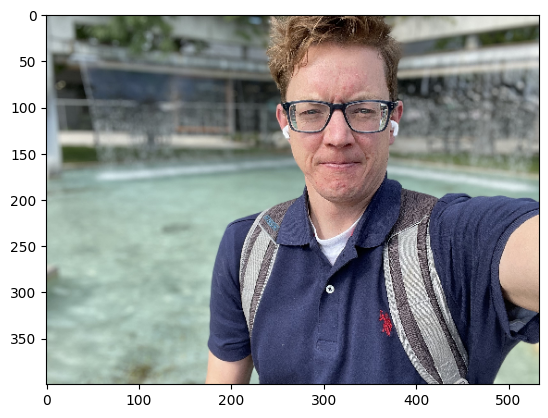

In [16]:
# prompt: Display an image

import matplotlib.pyplot as plt

img = keras.utils.load_img(base_image_path, target_size=(img_height, img_width))
plt.imshow(img)
plt.show()


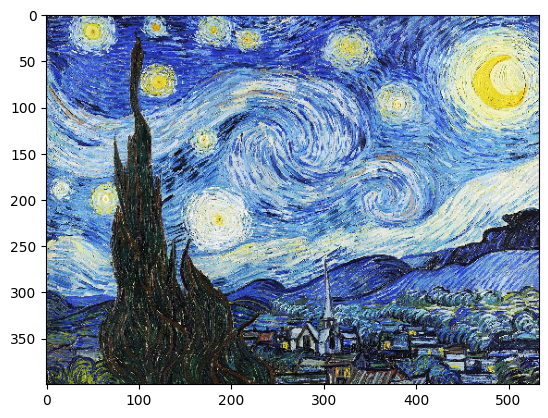

In [18]:
img = keras.utils.load_img('/root/.keras/datasets/starry_night.jpg', target_size=(img_height, img_width))
plt.imshow(img)
plt.show()

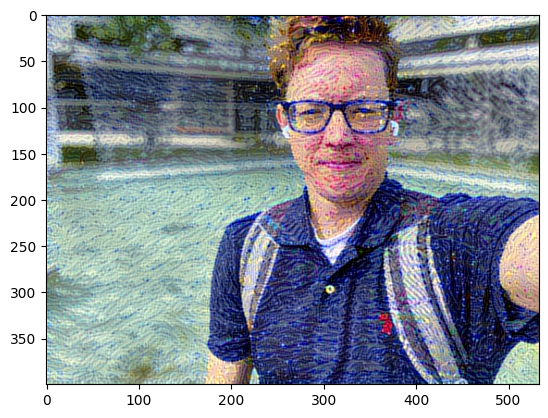

In [17]:
img = keras.utils.load_img('combination_selfie_at_iteration_300.png', target_size=(img_height, img_width))
plt.imshow(img)
plt.show()